In [5]:
%load_ext autoreload
%matplotlib inline

In [6]:
%autoreload 2

import sys,os,glob
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm

import xarray as xr
import numpy as np
import pandas as pd
from pprint import pprint
import cartopy.crs as ccrs

In [28]:
# Where are we?
import socket
print(socket.gethostname())

l40106.lvt.dkrz.de


# SAM-4km (DYAMOND-summer)

List all DYAMOND variables

In [25]:
! ls /work/bk1040/DYAMOND/data/summer_data/SAM-4km/

datadescription.txt  OUT_2D  OUT_3D  README


In [31]:
# # !! On spirit
# path_dy = '/bdd/DYAMOND/SAM-4km/'

# !! on dkrz
path_dy = '/work/bk1040/DYAMOND/data/summer_data/SAM-4km'

path_dy_2D = os.path.join(path_dy,'OUT_2D')
path_dy_3D = os.path.join(path_dy,'OUT_3D')

In [4]:
# ! on spirit
! cat /bdd/DYAMOND/SAM-4km/README

Each output file contains only one field. 
The 2D output was written every 30 min, 3D output was written every 3 h.
The exception the soil surface temperature S_TS1 and water content S_WS1, which were written every hour.

The file names themselves contain the timestep that it was written on. 
To compute time in seconds since Aug 1, take that step and multiply by timestep 7.5s.
For example, file DYAMOND_9216x4608x74_7.5s_4km_4608_0000230160.V10m.2D.nc correspoinds to 
230160*7.5 = 1726200 s since Aug 1, or 19.98 days.
Also, each file has the time variable that contains the fractional calendar day.


In [29]:
# ! on spirit
! ls -lh /bdd/DYAMOND/SAM-4km/OUT_2D/DYAMOND_9216x4608x74_7.5s_4km_4608_0000395760.Precac.2D.nc

ls: cannot access '/bdd/DYAMOND/SAM-4km/OUT_2D/DYAMOND_9216x4608x74_7.5s_4km_4608_0000395760.Precac.2D.nc': No such file or directory


Write or find a method to load 3hr Prec data from Precac variable

In [32]:
varids = list(set([s.split('.')[-3] for s in glob.glob(os.path.join(path_dy_2D,'*'))]))
varids.sort()
print(varids)

['5s_4km_4608_ZSFC', 'CWP', 'GWP', 'IWP', 'LANDMASK', 'LHF', 'LWDSA', 'LWNSA', 'LWNTA', 'OM500', 'OM700', 'OM850', 'PSFC', 'PW', 'Precac', 'Q2m', 'RH500', 'RH700', 'RH850', 'RWP', 'SHF', 'SWDSA', 'SWNSA', 'SWNTA', 'SWP', 'S_TS1', 'S_WS1', 'T2mm', 'TAUX', 'TAUY', 'U10m', 'V10m']


Load precipitation data

In [33]:
varid = 'Precac'
timestep = 279360

def getPath(varid,timestep,dataset='DYAMOND'):
    
    if dataset == 'DYAMOND':
        timestep_str = '{:010}'.format(timestep)
        # on spirit
        rootpath_dy = '/bdd/DYAMOND/SAM-4km/OUT_2D/DYAMOND_9216x4608x74_7.5s_4km_4608'
        # on dkrz
        path = '%s_%s.%s.2D.nc'%(rootpath_dy,timestep_str,varid)
    
    return path

precac = xr.open_dataset(getPath(varid,timestep))


FileNotFoundError: [Errno 2] No such file or directory: b'/DYAMOND_9216x4608x74_7.5s_4km_4608_0000279360.Precac.2D.nc'

In [6]:
precac

<xarray.Dataset>
Dimensions:  (lat: 4608, lon: 9216, time: 1)
Coordinates:
  * lat      (lat) float32 -88.98 -88.94 -88.9 -88.86 ... 88.86 88.9 88.94 88.98
  * lon      (lon) float32 0.01953 0.05859 0.09766 0.1367 ... 359.9 359.9 360.0
  * time     (time) float32 238.2
Data variables:
    Precac   (time, lat, lon) float32 ...
Attributes:
    history:  Sat Jul 28 10:43:42 2018: ncks -v Precac /gpfs/p/unsb0007/SAM7....
    NCO:      netCDF Operators version 4.7.4 (http://nco.sf.net)

Text(0, 0.5, 'Precipitation (mm)')

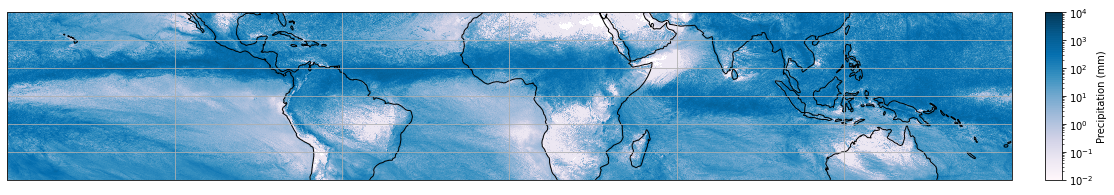

In [10]:
fig = plt.figure(figsize=(18,5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

cmap = plt.cm.PuBu

data = precac.Precac[0]
lon_lim = (0,360)
lat_lim = (-30,30)
slice_lat = slice(*lat_lim)
slice_lon = slice(*lon_lim)
clim = (1e-2,1e4)

# ax.imshow(precac.Precac[0])
lat_dyamond = data.lat.sel(lat=slice_lat).data
lon_dyamond = data.lon.sel(lon=slice_lon).data

lonarray_dyamond,latarray_dyamond = np.meshgrid(lon_dyamond,lat_dyamond)

# background
Z = data.sel(lon=slice_lon,lat=slice_lat)
# Z = Precac_DYAMOND.sel(lon=slice_lon,lat=slice_lat)[0]

im = ax.pcolormesh(lonarray_dyamond,latarray_dyamond,Z,transform=ccrs.PlateCarree(),
              alpha=0.9,cmap=cmap,norm=LogNorm(vmin=clim[0],vmax=clim[1]))
# im.set_clim(*clim)


# geography
# ax.set_extent([lon_lim[0]-360,lon_lim[1], *lat_lim],crs=ccrs.PlateCarree(central_longitude=0))
ax.coastlines('110m')
ax.gridlines()

# colorbar
x,y,w,h = ax.get_position().bounds
dx = w/60
cax = plt.axes([x+w+2*dx,y,dx,h])
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.set_ylabel('Precipitation (mm)')


Precipitation data is accumulated since the beginning of the simulation. 3hr prec data can then be retrieved by differentiating consecutive time steps. 

In [11]:
precac

<xarray.Dataset>
Dimensions:  (lat: 4608, lon: 9216, time: 1)
Coordinates:
  * lat      (lat) float32 -88.98 -88.94 -88.9 -88.86 ... 88.86 88.9 88.94 88.98
  * lon      (lon) float32 0.01953 0.05859 0.09766 0.1367 ... 359.9 359.9 360.0
  * time     (time) float32 238.2
Data variables:
    Precac   (time, lat, lon) float32 ...
Attributes:
    history:  Sat Jul 28 10:43:42 2018: ncks -v Precac /gpfs/p/unsb0007/SAM7....
    NCO:      netCDF Operators version 4.7.4 (http://nco.sf.net)

# MPI-DWD-DKRZ (DYAMOND-winter)

In [7]:
# !! on dkrz
path_dy = '/work/bk1040/DYAMOND/data/winter_data/DYAMOND_WINTER/MPIM-DWD-DKRZ/ICON-NWP-2km/DW-ATM/atmos/'
subpath_pr = '15min/pracc/r1i1p1f1/2d/gn'

In [2]:
! ls $path_dy/15min/pracc/r1i1p1f1/2d/gn

pracc_15min_ICON-NWP-2km_DW-ATM_r1i1p1f1_2d_gn_20200120000000-20200120234500.nc
pracc_15min_ICON-NWP-2km_DW-ATM_r1i1p1f1_2d_gn_20200121001500-20200121234500.nc
pracc_15min_ICON-NWP-2km_DW-ATM_r1i1p1f1_2d_gn_20200122001500-20200122234500.nc
pracc_15min_ICON-NWP-2km_DW-ATM_r1i1p1f1_2d_gn_20200123000000-20200123234500.nc
pracc_15min_ICON-NWP-2km_DW-ATM_r1i1p1f1_2d_gn_20200124001500-20200124234500.nc
pracc_15min_ICON-NWP-2km_DW-ATM_r1i1p1f1_2d_gn_20200125001500-20200125234500.nc
pracc_15min_ICON-NWP-2km_DW-ATM_r1i1p1f1_2d_gn_20200126001500-20200126234500.nc
pracc_15min_ICON-NWP-2km_DW-ATM_r1i1p1f1_2d_gn_20200127001500-20200127234500.nc
pracc_15min_ICON-NWP-2km_DW-ATM_r1i1p1f1_2d_gn_20200128001500-20200128234500.nc
pracc_15min_ICON-NWP-2km_DW-ATM_r1i1p1f1_2d_gn_20200129001500-20200129234500.nc
pracc_15min_ICON-NWP-2km_DW-ATM_r1i1p1f1_2d_gn_20200130001500-20200130234500.nc
pracc_15min_ICON-NWP-2km_DW-ATM_r1i1p1f1_2d_gn_20200131001500-20200131234500.nc
pracc_15min_ICON-NWP-2km_DW-ATM_r1i1p1f1

In [3]:
file1 = 'pracc_15min_ICON-NWP-2km_DW-ATM_r1i1p1f1_2d_gn_20200120000000-20200120234500.nc'

In [8]:
data = xr.open_dataset(os.path.join(path_dy,subpath_pr,file1))

In [9]:
data.pracc

<xarray.DataArray 'pracc' (time: 96, ncells: 83886080)>
[8053063680 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 ... 2020-01-20T23:45:00
Dimensions without coordinates: ncells
Attributes:
    long_name:                    Total Precipitation (Accumulation)
    units:                        kg m-2
    param:                        52.1.0
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1
    standard_name:                precipitation_flux_accumulated
    origin:                       TOT_PREC
    coordinates:                  clon clat

# ARPEGE (DYAMOND-winter)

In [10]:
! ls /work/bk1040/DYAMOND/data/winter_data/DYAMOND_WINTER/METEOFR/ARPEGE-NH-2km/DW-ATM/atmos/

15min  3hr  fx


In [11]:
path_arpege = '/work/bk1040/DYAMOND/data/winter_data/DYAMOND_WINTER/METEOFR/ARPEGE-NH-2km/DW-ATM/atmos'
subpath_pr = '15min/pr/r1i1p1f1/2d/gn'

In [12]:
! ls $path_arpege/$subpath_pr

pr_15min_ARPEGE-NH-2km_DW-ATM_r1i1p1f1_2d_gn_20200120001500-20200121000000.nc
pr_15min_ARPEGE-NH-2km_DW-ATM_r1i1p1f1_2d_gn_20200121001500-20200122000000.nc
pr_15min_ARPEGE-NH-2km_DW-ATM_r1i1p1f1_2d_gn_20200122001500-20200123000000.nc
pr_15min_ARPEGE-NH-2km_DW-ATM_r1i1p1f1_2d_gn_20200123001500-20200124000000.nc
pr_15min_ARPEGE-NH-2km_DW-ATM_r1i1p1f1_2d_gn_20200124001500-20200125000000.nc
pr_15min_ARPEGE-NH-2km_DW-ATM_r1i1p1f1_2d_gn_20200125001500-20200126000000.nc
pr_15min_ARPEGE-NH-2km_DW-ATM_r1i1p1f1_2d_gn_20200126001500-20200127000000.nc
pr_15min_ARPEGE-NH-2km_DW-ATM_r1i1p1f1_2d_gn_20200127001500-20200128000000.nc
pr_15min_ARPEGE-NH-2km_DW-ATM_r1i1p1f1_2d_gn_20200128001500-20200129000000.nc
pr_15min_ARPEGE-NH-2km_DW-ATM_r1i1p1f1_2d_gn_20200129001500-20200130000000.nc
pr_15min_ARPEGE-NH-2km_DW-ATM_r1i1p1f1_2d_gn_20200130001500-20200131000000.nc
pr_15min_ARPEGE-NH-2km_DW-ATM_r1i1p1f1_2d_gn_20200131001500-20200201000000.nc
pr_15min_ARPEGE-NH-2km_DW-ATM_r1i1p1f1_2d_gn_20200201001500-2020

In [13]:
file_arp = 'pr_15min_ARPEGE-NH-2km_DW-ATM_r1i1p1f1_2d_gn_20200120001500-20200121000000.nc'

In [14]:
data = xr.open_dataset(os.path.join(path_arpege,subpath_pr,file_arp))

In [15]:
data

<xarray.Dataset>
Dimensions:         (time: 96, reduced_points: 8100, lat: 8100, rgrid: 85189724)
Coordinates:
  * time            (time) datetime64[ns] 2020-01-20T00:15:00 ... 2020-01-21
  * reduced_points  (reduced_points) int32 18 24 32 40 48 50 ... 48 40 32 24 18
  * lat             (lat) float64 89.98 89.96 89.94 ... -89.94 -89.96 -89.98
Dimensions without coordinates: rgrid
Data variables:
    pr              (time, rgrid) float32 ...
Attributes:
    CDI:                       Climate Data Interface version 2.0.0rc2 (https...
    Conventions:               CF-1.6
    history:                   Thu Jun 17 21:00:45 2021: cdo -P 4 -f nc4 -z z...
    CDO:                       Climate Data Operators version 2.0.0rc3 (https...
    cdo_openmp_thread_number:  4

In [16]:
! ls $path_arpege/fx/grid/r1i1p1f1/2d/gn

grid_fx_ARPEGE-NH-2km_DW-CPL_r1i1p1f1_2d_gn_fx.nc


In [17]:
subpath_grid = 'fx/grid/r1i1p1f1/2d/gn'
file_grid = 'grid_fx_ARPEGE-NH-2km_DW-CPL_r1i1p1f1_2d_gn_fx.nc'

In [18]:
grid = xr.open_dataset(os.path.join(path_arpege,subpath_grid,file_grid))

In [19]:
grid

<xarray.Dataset>
Dimensions:    (rgrid: 85189724, nv: 4)
Coordinates:
    clon       (rgrid) float64 ...
    clat       (rgrid) float64 ...
Dimensions without coordinates: rgrid, nv
Data variables:
    clon_bnds  (rgrid, nv) float64 ...
    clat_bnds  (rgrid, nv) float64 ...
    grid       (rgrid) float32 ...
Attributes:
    history:  Thu Aug 12 11:56:15 2021: ncrename -v lml,grid /mnt/lustre02/wo...
    NCO:      netCDF Operators version 4.7.5 (Homepage = http://nco.sf.net, C...